In [410]:
#Iliana Kogia AEM:10090

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC
from statistics import mean

In [411]:
data = pd.read_csv(r"dataset.csv", header = None) #load dataset

X = data.iloc[:,:2] # first 2 cols == features
y = data.iloc[:,-1] # last column == labels
X = np.array(X) #convert to np array
y = np.array(y) #convert to np array

(array([ 4., 20., 24., 50., 76., 60., 35., 10.,  0.,  1.]),
 array([-1.1722 , -0.06997,  1.03226,  2.13449,  3.23672,  4.33895,
         5.44118,  6.54341,  7.64564,  8.74787,  9.8501 ]),
 <BarContainer object of 10 artists>)

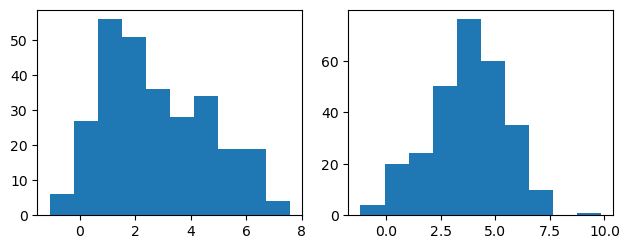

In [412]:
plt.subplot(2,2,1)
plt.hist(X[:,0])
plt.subplot(2,2,2)
plt.hist(X[:,1])

In [413]:
#split data train-test: 50%-50%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42) 

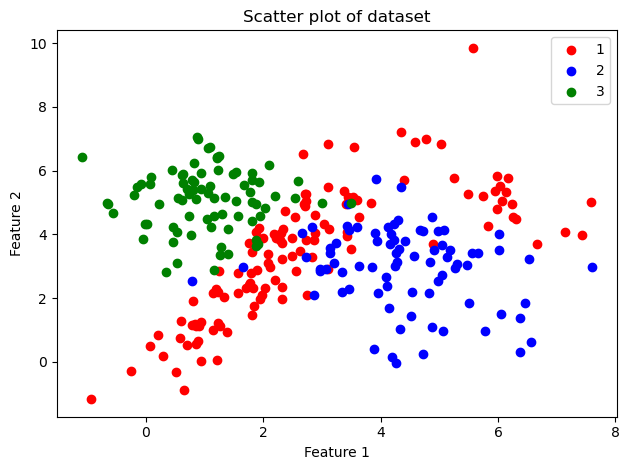

In [414]:
# plot all data
label_color_map = {1: 'red', 2: 'blue', 3: 'green'} #map the 3 labels to 3 different colors
for label, color in label_color_map.items():
    class_points = X[y == label]
    plt.scatter(class_points[:,0], class_points[:,1], color = color, label = label)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter plot of dataset')
plt.legend()
plt.show()

In [415]:
# #preprocess data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [417]:
#find samples per class
unique_classes, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} samples")
#plt.subplot(2,2,1)
#plt.bar(unique_classes, counts, color='blue')

Class 1: 53 samples
Class 2: 39 samples
Class 3: 48 samples


In [389]:
#-------------------------MEROS A------------------------------
# define the functions that will use for Q1,Q2,Q3 of part A

def calculate_covarMatrix_S(X_train_c, mean_c, N_c):
    S = np.zeros((2,2))
    for i in range(N_c):
        S += (X_train_c[i,:].reshape(-1,1) - mean_c) @ (X_train_c[i,:].reshape(-1,1) - mean_c).T
    S =  S / N_c 
    return S

def MaximumLikelihoodEst(X_train, y_train, num_classes):
    # initialize
    S_matrices = [] #a list with covariance marices for each class
    m_values = [] #a list with mean values of each class
    N = [] #number of samples of each class
    # for each class find Maximum Likelihood estimations of parameters m and S
    for c in range(1, num_classes+1): 
        #find the samples of class c :
        indices = np.where(y_train == c)[0]  
        X_train_c = X_train[indices]
        y_train_c = y_train[indices]

        #find mean values for these samples 
        mean_c = np.mean(X_train_c, axis = 0).reshape(-1,1) #mean along the cols
        #find covariance matrix of these samples
        N_c = X_train_c.shape[0]
        Si = calculate_covarMatrix_S(X_train_c, mean_c, N_c)

        #store to lists
        S_matrices.append(Si)
        N.append(N_c)
        m_values.append(mean_c)
        
    return S_matrices, N, m_values

def discriminantFun_case1(x, m, S, P):
    Sinv = np.linalg.inv(S)
    g = (-1/2) * ((x - m).T) @ Sinv @ (x - m) + np.log(P) 
    return g

def discriminantFun_case2(x, m, S, P, d = 2):
    Sinv = np.linalg.inv(S)
    g = (-1/2) * ((x - m).T) @ Sinv @ (x - m) + np.log(P) + (-1/2) * np.log(np.linalg.norm(Sinv))
    return g

def predict_case_1(X_test, S_same, N, m_values, num_classes, Prob):
    y_pred = []
    for i in range(X_test.shape[0]):
        x = X_test[i,:].reshape(-1,1) #sample i 
        g = []
        for c in range(num_classes):
            gi = discriminantFun_case1(x, m_values[c], S_same, Prob[c])
            g.append(gi)
        
        g_max_index = g.index(max(g)) #find the maximum value of the discriminants gi
        predicted_label = g_max_index + 1 #find the label of the best class for this sample
        y_pred.append(predicted_label)
    
    y_pred = np.array(y_pred).reshape(-1,1)
    return y_pred

def predict_case_2(X_test, S_matrices, N, m_values, num_classes, Prob):
    y_pred = []
    for i in range(X_test.shape[0]):
        x = X_test[i,:].reshape(-1,1) #sample i 
        g = []
        for c in range(num_classes):
            gi = discriminantFun_case2(x, m_values[c], S_matrices[c], Prob[c])
            g.append(gi)
        
        g_max_index = g.index(max(g)) #find the maximum value of the discriminants gi
        predicted_label = g_max_index + 1 #find the label of the best class for this sample
        y_pred.append(predicted_label)
    
    y_pred = np.array(y_pred).reshape(-1,1)
    return y_pred


In [390]:
num_classes = 3

#find ML estimations for params m, S
S_matrices, N, m_values = MaximumLikelihoodEst(X_train, y_train, num_classes)

#find apriori probabilities P(wi) and save to list Prob
N_samples = X_train.shape[0]
Prob = [(N[0] / N_samples), (N[1] / N_samples), (N[2] / N_samples)] 

#-------------Bayes Classifier--------------------

#-------------------Q1-----------------------------
# same covariance matrix Si == S
S_same = ((N[0] / N_samples) * S_matrices [0] + (N[1] / N_samples) * S_matrices [1] + (N[2] / N_samples) * S_matrices [2])
y_pred_1_test = predict_case_1(X_test, S_same, N, m_values, num_classes, Prob)
print("Case 1:\nAccuracy in test set:", 100*accuracy_score(y_pred_1_test, y_test))

#-------------------Q2-----------------------------
# different covariance matrix Si for each class
y_pred_2_test = predict_case_2(X_test, S_matrices, N, m_values, num_classes, Prob)
print("Case 2:\nAccuracy in test set:",100*accuracy_score(y_pred_2_test, y_test))

Case 1:
Accuracy in test set: 74.28571428571429
Case 2:
Accuracy in test set: 82.14285714285714


In [391]:
# define function for Q3
def decisionBoundary(X_train, y_train, h , predict, S, N, m_values, num_classes, Prob, clf = None):
    # Plot the decision boundary
    # assign a color to each point in the mesh [x_min, x_max] x [y_min, y_max]
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    if clf == None:
        Z = predict(np.c_[xx.ravel(), yy.ravel()], S, N, m_values, num_classes, Prob)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    return xx, yy, Z

Text(0.5, 1.0, 'Bayes classifier (test data)\ncase: S = same')

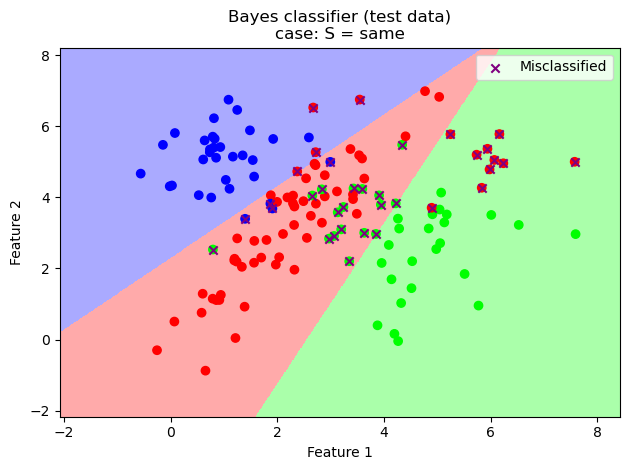

In [392]:
#-------------------Q3-----------------------------
#-----------------CASE 1---------------------------
xx, yy, Z = decisionBoundary(X_train, y_train, 0.01, predict_case_1, S_same, N, m_values, num_classes, Prob)

#color-maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure()
#Plot decision boundary
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Plot the testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold)
# Plot misclassified points
misclassified_indices = np.where(y_pred_1_test != y_test.reshape(-1,1))[0]
plt.scatter(X_test[misclassified_indices, 0], X_test[misclassified_indices, 1], c='purple', marker='x', label='Misclassified')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title("Bayes classifier (test data)\ncase: S = same")

Text(0.5, 1.0, 'Bayes classifier (test data)\ncase: S = Si')

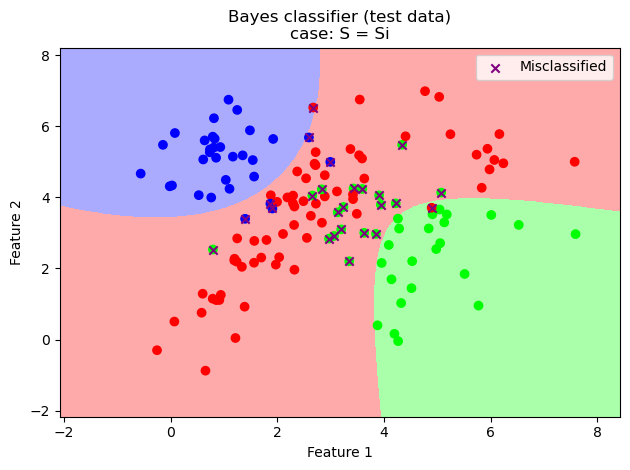

In [393]:
#-------------------Q3-----------------------------
#-----------------CASE 2---------------------------
xx, yy, Z = decisionBoundary(X_train, y_train, 0.01, predict_case_2, S_matrices, N, m_values, num_classes, Prob)

#color-maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure()
#Plot decision boundary
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Plot the testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold)
# Plot misclassified points
misclassified_indices = np.where(y_pred_2_test != y_test.reshape(-1,1))[0]
plt.scatter(X_test[misclassified_indices, 0], X_test[misclassified_indices, 1], c='purple', marker='x', label='Misclassified')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title("Bayes classifier (test data)\ncase: S = Si")

In [394]:
# #preprocess data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

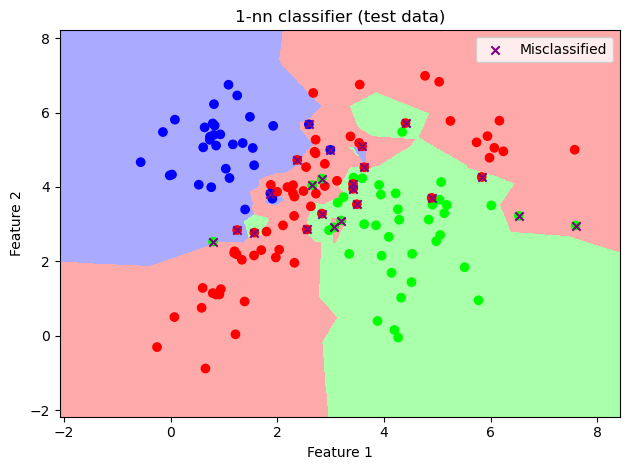

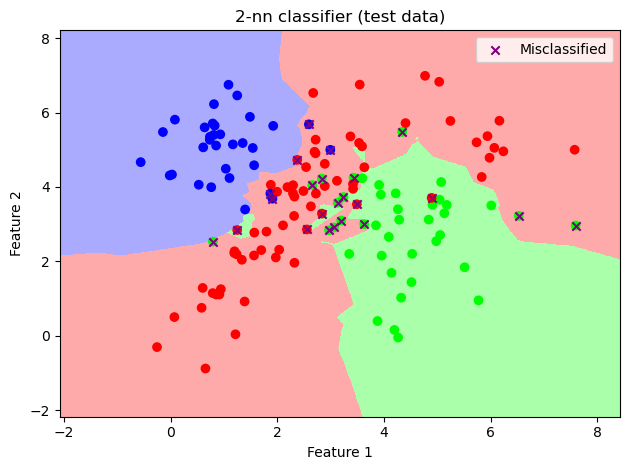

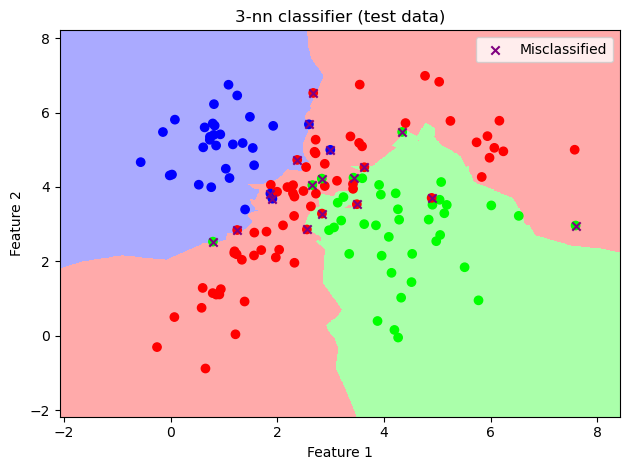

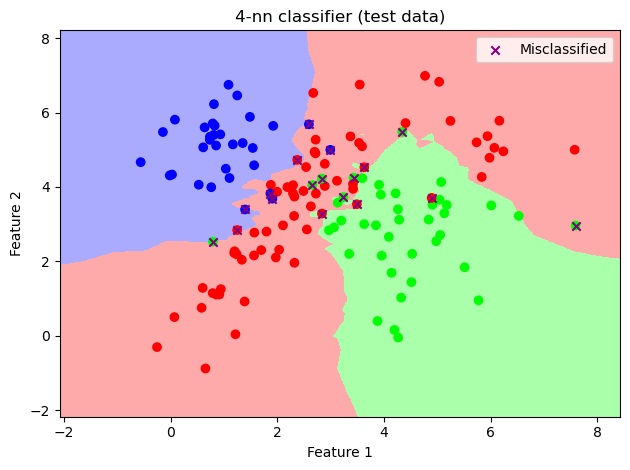

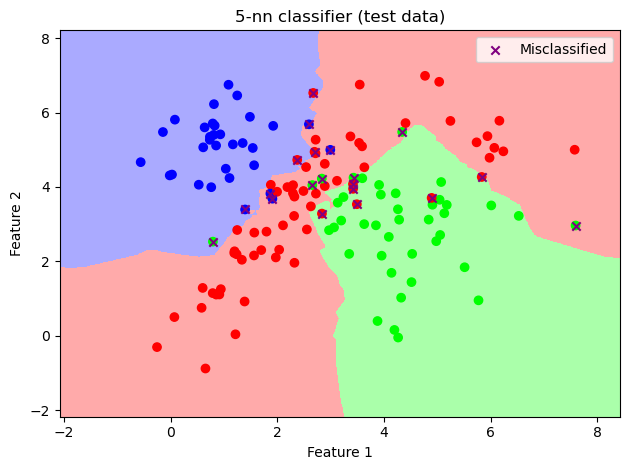

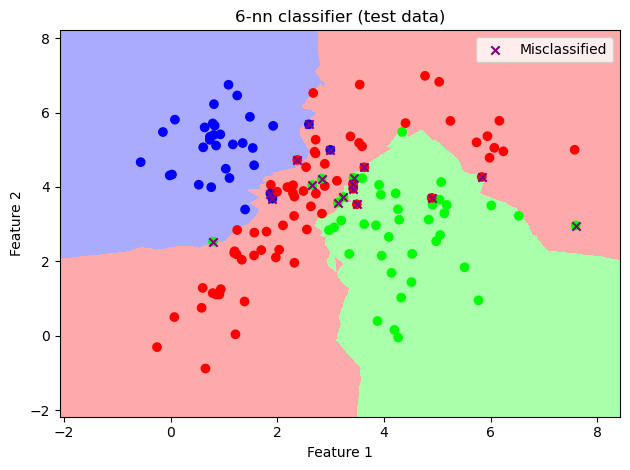

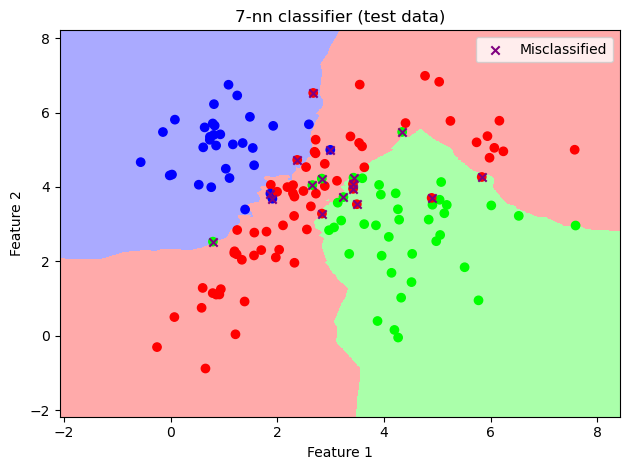

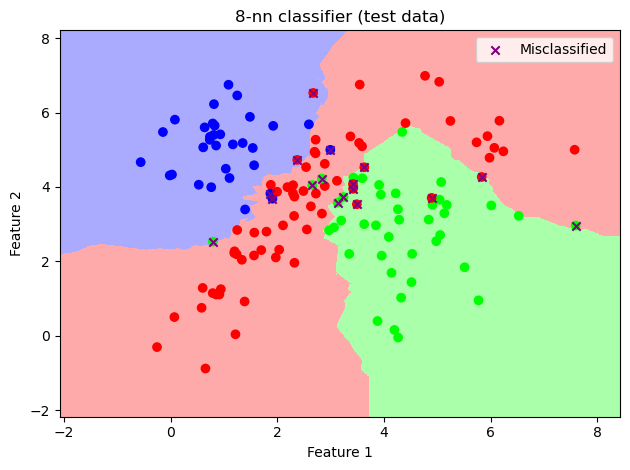

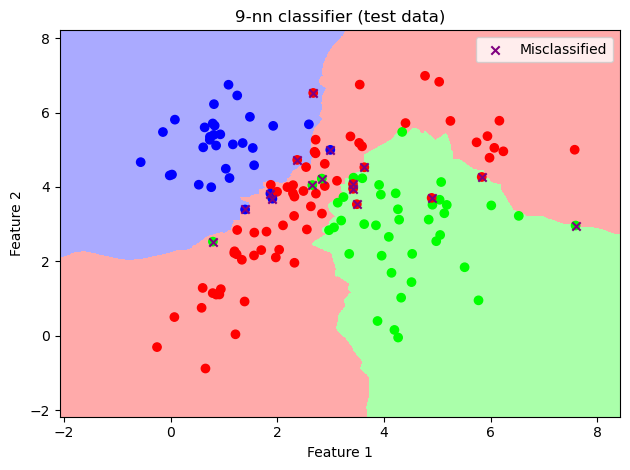

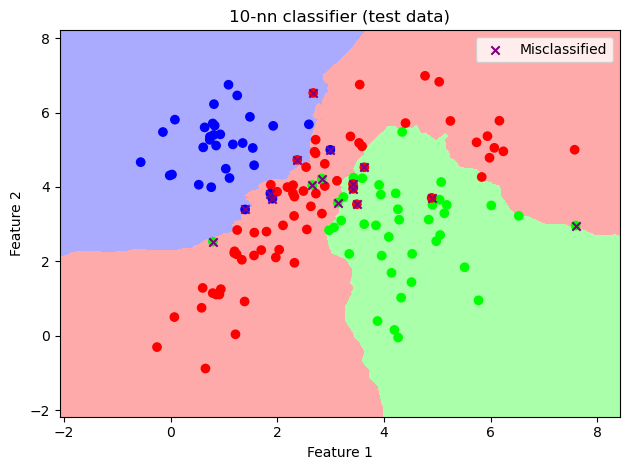

In [395]:
#-------------------------MEROS B------------------------------
#Train with k-NN classifier for k = 1,...,10
accuracy_scores = []
errors = []
k_values = np.arange(1,11)
for k in k_values:
    knnClassifier = KNeighborsClassifier(n_neighbors=k) #k - Nearest Neighbour Classifier
    knnClassifier.fit(X_train, y_train) # fit to train set
    y_pred_test = knnClassifier.predict(X_test) #prediction in test set
    accuracy = accuracy_score(y_test, y_pred_test) #find accuracy
    accuracy_scores.append(accuracy*100) #save
    classification_error = 1 - accuracy #classification error in test set
    errors.append(classification_error*100) #save
    #-------------------Q3-----------------------------
    xx, yy, Z = decisionBoundary(X_train, y_train, 0.01, None, None, None, None, None, None, clf = knnClassifier)
    plt.rcParams["figure.autolayout"] = True
    #color-maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    plt.figure()
    #Plot decision boundary
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot the testing points
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold)
    # Plot misclassified points
    misclassified_indices = np.where(y_pred_test != y_test)[0]
    plt.scatter(X_test[misclassified_indices, 0], X_test[misclassified_indices, 1], c='purple', marker='x', label='Misclassified')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.title("%i-nn classifier (test data)" % (k))

Best k : k = 9  and accuracy in test set =  88.57142857142857


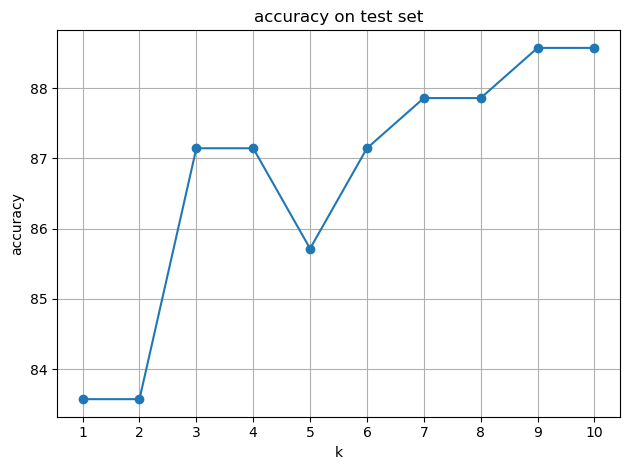

In [399]:
best_k = k_values[np.argmax(accuracy_scores)]
best_accuracy = np.max(accuracy_scores)
print("Best k : k =", best_k, " and accuracy in test set = ",  best_accuracy)

plt.plot(k_values, accuracy_scores, marker = 'o')
plt.xlabel("k")
plt.xticks(k_values)
plt.ylabel("accuracy")
plt.title("accuracy on test set")
plt.grid(True)
plt.show()


best params:  {'C': 1}
train accuracy: 80.71428571428572
test accuracy: 78.57142857142857


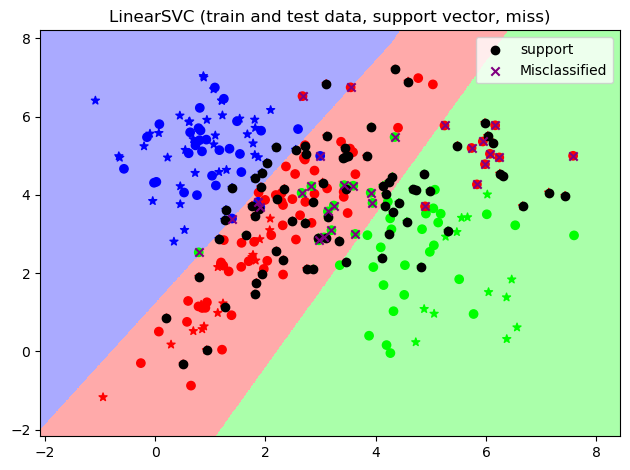

In [424]:
#-------------------------MEROS C------------------------------
#---------------------------Q1---------------------------------
#LinearSVM
parameters = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 1, 10, 100, 1000],
              }
model = SVC(kernel = 'linear')
SVM_grid = GridSearchCV(model,
                        parameters,
                        #verbose=3,
                        cv=10) # Cross validation Κ=10

SVM_grid.fit(X_train, y_train) #fit
print('best params: ',SVM_grid.best_params_)
best_SVM = SVM_grid.best_estimator_ #best estimator

y_pred_tr = best_SVM.predict(X_train) #predict train data
accuracy_tr = accuracy_score(y_train, y_pred_tr)
print('train accuracy:', 100*accuracy_tr)
y_pred_ts = best_SVM.predict(X_test) #predict test data
accuarcy_ts = accuracy_score(y_test, y_pred_ts)
print('test accuracy:', 100*accuarcy_ts)

#-------------------Q3-----------------------------
xx, yy, Z = decisionBoundary(X_train, y_train, 0.01, None, None, None, None, None, None, clf = best_SVM)

#color-maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure()
#Plot decision boundary
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

#Plot the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker = '*', cmap=cmap_bold)

# Plot the testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold)

#Plot support vectors
X_support = X_train[best_SVM.support_]
y_support = y_train[best_SVM.support_]
plt.scatter(X_support[:, 0], X_support[:, 1], c='black', marker = 'o', label='support')

# Plot misclassified points
misclassified_indices = np.where(y_pred_ts != y_test)[0]
plt.scatter(X_test[misclassified_indices, 0], X_test[misclassified_indices, 1], c='purple', marker='x', label='Misclassified')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.legend()
plt.title("LinearSVC (train and test data, support vector, miss)" )
plt.show()

{'C': 1, 'gamma': 0.1}
train accuracy: 92.85714285714286
test accuracy: 88.57142857142857


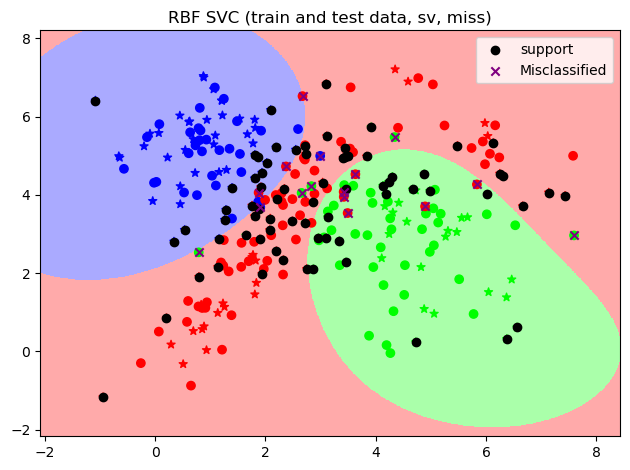

In [423]:
#---------------------------Q2---------------------------------
#RBF kernel SVM
parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
              'gamma' : [0.1, 0.4, 0.01,0.04, 0.001, 0.004, 0.0001]
              }

model = SVC(kernel = 'rbf')
SVM_grid = GridSearchCV(model,
                        parameters,
                        #verbose=3,
                        cv=10) # Cross validation Κ=10

SVM_grid.fit(X_train, y_train)

print(SVM_grid.best_params_)

best_SVM = SVM_grid.best_estimator_

y_pred_tr = best_SVM.predict(X_train)
accuracy_tr = accuracy_score(y_train, y_pred_tr)
print('train accuracy:', 100*accuracy_tr)
y_pred_ts = best_SVM.predict(X_test)
accuarcy_ts = accuracy_score(y_test, y_pred_ts)
print('test accuracy:', 100*accuarcy_ts)

#-------------------Q3-----------------------------
xx, yy, Z = decisionBoundary(X_train, y_train, 0.01, None, None, None, None, None, None, clf = best_SVM)

#color-maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure()
#Plot decision boundary
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

#Plot the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker = '*', cmap=cmap_bold)

# Plot the testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold)

#Plot support vectors
X_support = X_train[best_SVM.support_]
y_support = y_train[best_SVM.support_]
plt.scatter(X_support[:, 0], X_support[:, 1], c='black', marker = 'o', label='support')

# Plot misclassified points
misclassified_indices = np.where(y_pred_ts != y_test)[0]
plt.scatter(X_test[misclassified_indices, 0], X_test[misclassified_indices, 1], c='purple', marker='x', label='Misclassified')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.legend()
plt.title("RBF SVC (train and test data, sv, miss)" )
plt.show()